# Homework #1

1. create a dataloader to load the galaxy10 dataset
2. build a classifier with a fully connceted neural network 
3. write a function to compute the classification accuracy of the network prediction
3. write a training loop and train the model
4. save the loss and accuracy for both the training dataset and the validation dataset after every epoch
5. plot the loss and accuracy
6. save the trained model and model source code (in a .py file)
7. email the trained model to jonathan.shlomi@weizmann.ac.il

In [1]:
path_to_training_data = './Dataset/train/'
path_to_validation_data = './/Dataset/validation/'

### The galaxy10 dataset

in this homework you will build a classifier for the galaxy10 dataset (https://astronn.readthedocs.io/en/latest/galaxy10.html)

but its a "special" version of the dataset created for this homework. The images have been converted to grayscale, and saved as png files in two directories, "train" and "validation". There is a seperate test dataset in a secret location, you will train a model, submit it, and we will evaluate it on the test dataset

you can submit the model once you have over 65% accuracy on the validation dataset. 


### DataLoader:

In [2]:
import glob
import re
import os
from PIL import Image

In [3]:
import sys

In [4]:
from torchvision import datasets, transforms
import numpy as np
import torch

In [5]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, path,mean=0.092,std=0.127,n_classes=10):
        
        
        self.mean = mean
        self.std = std

        
        self.filelist = glob.glob(path+'/*.png') 
        #....
        self.labels =  torch.LongTensor([int(re.search('(?<=class)[0-9]',os.path.basename(file)).group(0)) for file in self.filelist])

    def __len__(self):
       
        return len(self.filelist)


    def __getitem__(self, idx):
        
        img = Image.open(self.filelist[idx])

        img = transforms.ToTensor()( img ).view(-1)
        
        
        x = (img-self.mean)/self.std
        
        y = self.labels[idx]
    
        return x, y

## Load Dataset - Train, Validation

In [6]:
batch_size = 120

In [7]:
# training_ds = CustomDataset(path_to_training_data,transform=True)
training_ds = CustomDataset(path_to_training_data)
validation_ds = CustomDataset(path_to_validation_data)

In [8]:
## lets also go ahead and create the data loaders,
## and set the batch size
training_dataloader = DataLoader(training_ds,batch_size=batch_size)
valid_dataloader = DataLoader(validation_ds,batch_size=batch_size)


since this is a small dataset, we don't have a memory constraint and its easy to evaluate on the whole dataset at once

In [9]:
training_tensor = torch.stack([training_ds[i][0] for i in range(len(training_ds)) ])
training_labels = training_ds.labels.data.numpy()

validation_tensor = torch.stack([validation_ds[i][0] for i in range(len(validation_ds)) ])
validation_labels = validation_ds.labels.data.numpy()

## Test Data Getter, Loader 

In [10]:
training_ds.__getitem__(0)

(tensor([-0.7244, -0.7244, -0.7244,  ..., -0.6935, -0.6627, -0.6935]),
 tensor(2))

In [11]:
some_random_idx = 52
training_ds[some_random_idx]

(tensor([-0.5391, -0.4774, -0.5700,  ..., -0.5700, -0.6009, -0.6009]),
 tensor(2))

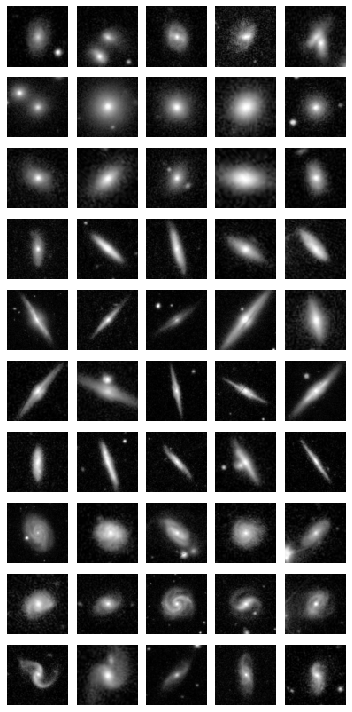

In [12]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(10,5,figsize=(5,10))


for class_i in range(10):
    idxs = np.where( training_ds.labels == class_i )[0]
    idxs = np.random.permutation(idxs)
    for plot_i in range(np.min([5,len(idxs)])):

        ax[class_i][plot_i].imshow(training_ds[idxs[plot_i]][0].reshape(69,69),cmap='gray')
        ax[class_i][plot_i].set_axis_off()
        
plt.tight_layout()
plt.show()

# Now lets build the neural network

its a classifier - it takes as input 69*69 numbers, and outputs 10 numbers

What you need to know:

The input is a vector of dimension 4,761

The output is a vector of dimension 10

Don’t apply an activation to the last layer

In [13]:
import torch.nn as nn

dim_input = 69*69
dim_sqrt = 69
classes = 10

In [14]:
import torch.nn.functional as F

In [15]:
# https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html#learn-more class Net(nn.Module):

class MnistConvNet(nn.Module):
    def __init__(self):
        super(MnistConvNet, self).__init__()

        # First 2D convolutional layer, taking in 1 input channel (image),
        # outputting 32 convolutional features, with a square kernel size of 3
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        # Second 2D convolutional layer, taking in the 32 input layers,
        # outputting 64 convolutional features, with a square kernel size of 3
        self.conv2 = nn.Conv2d(32, 64, 3, 1)

        # Designed to ensure that adjacent pixels are either all 0s or all active
        # with an input probability
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)

        # First fully connected layer
        self.fc1 = nn.Linear(64*32*32, 128)
        # Second fully connected layer that outputs our 10 labels
        self.fc2 = nn.Linear(128, classes)

        # x represents our data
    def forward(self, x):
#         print('raw_x',x.size())
        # Pass data through conv1
        x = self.conv1(x)
#         print('nn.Conv2d (1,32,2,1) -->', x.size())
        # Use the rectified-linear activation function over x
        x = F.relu(x)
#         print('F.relu -->', x.size())
        x = self.conv2(x)
#         print('nn.Conv2d(32,64,3,1) -->', x.size())
        x = F.relu(x)
#         print('F.relu -->',x.size())

        # Run max pooling over x
        x = F.max_pool2d(x, 2)
#         print('F.max_pool2d(x,2) --> ',x.size())
        # Pass data through dropout1
        x = self.dropout1(x)
#         print('nn.Dropout2d(0.25) --> ',x.size())
        # Flatten x with start_dim=1
        x = torch.flatten(x, 1)
#         print('torch.flatten(x,1) -->',x.size())
        # Pass data through fc1
        x = self.fc1(x)
#         print('nn.Linear(69*69,128) --> ',x.size())
        x = F.relu(x)
#         print('F.relu(x) -->',x.size())
        x = self.dropout2(x)
#         print('nn.Dropout2d(0.5) -->',x.size())
        x = self.fc2(x)
#         print('nn.Linear(128,classes) -->',x.size())

        # Apply softmax to x
        #       output = F.log_softmax(x, dim=1)
        output = x
        return output
    
    # helper
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [16]:
# epoch 10:: loss: 1.6232141256332397, accuracy 0.5151785714285714
class DumbNet(nn.Module):
    def __init__(self):
        super(DumbNet,self).__init__()
        
        #...anything more interesting?? -- try cnn
        self.layer1 = nn.Linear(dim_input, classes)
        
        
    
    def forward(self,x):
        
        out = self.layer1(x)
        

        return out

## Net Instance

In [17]:
# uncomment if run on gpu sys, colab
# print('torch.cuda.is_available?',torch.cuda.is_available())
# if torch.cuda.is_available():
#     net.cuda()
    

## Define Loss function

In [18]:
# Use nn.CrossEntropyLoss()
# -
import torch.optim as optim
loss_func = nn.CrossEntropyLoss()


accuracy is defined as the number of correctly classifier samples out of the whole dataset

## Define Net, Optimizer, Hyperparameters

In [19]:
## create the instance

net = MnistConvNet()
net_name = 'MnistConvNet'
optim_name = 'SGD'
lr_param = '0.001'
momentum_param = '0.9'

reload after dead kernel

In [20]:
net.load_state_dict(torch.load('MnistConvNet_epoch_49_optim_SGD_lr_0.001_m_0.9.pt'))


<All keys matched successfully>

In [21]:
# Create an optimiser and set the learning rate (start with SGD and lr = 0.01 )
# -
# TODO trial different optimization and lr params
# optimizer = optim.SGD(net.parameters(), lr=0.01) 
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train, Eval Network

In [22]:
def dataset_accuracy(net, loss_func=loss_func, tensor_dataset=validation_tensor, targets=validation_labels):

    net.eval()
# toggle for cnn
    tensor_dataset = tensor_dataset.reshape(tensor_dataset.size()[0], 1, dim_sqrt,dim_sqrt)
    output = net(tensor_dataset)
    
    loss = loss_func(output,torch.LongTensor(targets))

    output = output.cpu().data.numpy()
    prediction = np.argmax(output,axis=1)

    n_correct = len(np.where(targets==prediction)[0])
    n_total = len(targets)

    return n_correct/n_total, loss.item()

In [23]:
# needs a jupyterlab build
# https://ipywidgets.readthedocs.io/en/stable/user_install.html#installing-the-jupyterlab-extension
from tqdm.notebook import tqdm,trange

https://discuss.pytorch.org/t/where-should-i-put-net-train/10236/2

From what I know train() enables some modules like dropout, and eval() does the opposit.

So I would say: before you start training your model call train() and then eval() when you are done. The classic workflow would be:

call train()
epoch of training on the training set
call eval()
evaluate your model on the validation set
repeat
eval() when you are done

In [25]:
# Write a training loop and compute the loss and accuracy at the end
# -
# Plot the losses and accuracies at the end
n_epochs = 100

loss_vs_epoch = []
accuracy_vs_epoch = []

for epoch in trange(50,n_epochs,desc='Epochs',file=sys.stdout):
    
#     accuracies = []

    net.train()
    
    for i,(x,y) in enumerate(training_dataloader):
#nn.Conv2d will take in a 4D Tensor of nSamples x nChannels x Height x Width.
# first dim batch size will be variable -- for last batch
        x = x.reshape(x.size()[0], 1, dim_sqrt,dim_sqrt)
    
        optimizer.zero_grad()

        y_hat = net(x)
        
#         accuracies.append(accuracy(y_hat,y))

        loss = loss_func(y_hat, y)
        loss.backward()
        optimizer.step()
        
#         print(f'batch {i} accuracy',accuracy(y_hat,y))

         # print statistics
#     def dataset_accuracy(tensor_dataset,targets,net,loss_func):
    training_accuracy, training_loss = dataset_accuracy(net=net,tensor_dataset=training_tensor,targets=training_labels)
    validation_accuracy, validation_loss = dataset_accuracy(net=net,tensor_dataset=validation_tensor,targets=validation_labels)

#     loss = eval_loss(net=net)
    
    loss_vs_epoch.append([training_loss, validation_loss])
    
    accuracy_vs_epoch.append([training_accuracy, validation_accuracy])
    
    torch.save(net.state_dict(), f'{net_name}_epoch_{epoch}_optim_{optim_name}_lr_{lr_param}_m_{momentum_param}.pt')

    print(f'epoch {epoch + 1}:: loss: {validation_loss}, accuracy {validation_accuracy}')

    print('=========================================')

epoch 51:: loss: 0.9318084716796875, accuracy 0.6778
epoch 52:: loss: 0.9258884787559509, accuracy 0.678
epoch 53:: loss: 0.9144444465637207, accuracy 0.6838
epoch 54:: loss: 0.9139114022254944, accuracy 0.6948
epoch 55:: loss: 0.9052160978317261, accuracy 0.6966
epoch 56:: loss: 0.9048795104026794, accuracy 0.6918
epoch 57:: loss: 0.895696759223938, accuracy 0.6952
epoch 58:: loss: 0.9056985378265381, accuracy 0.693
epoch 59:: loss: 0.8943132758140564, accuracy 0.6944
epoch 60:: loss: 0.8955076932907104, accuracy 0.6884
epoch 61:: loss: 0.8914696574211121, accuracy 0.698
epoch 62:: loss: 0.8873549103736877, accuracy 0.6972
epoch 63:: loss: 0.8830804824829102, accuracy 0.7046
epoch 64:: loss: 0.879616379737854, accuracy 0.7042
epoch 65:: loss: 0.8832830190658569, accuracy 0.6958
epoch 66:: loss: 0.8795152306556702, accuracy 0.7
epoch 67:: loss: 0.8733474612236023, accuracy 0.7064
epoch 68:: loss: 0.8713928461074829, accuracy 0.707
epoch 69:: loss: 0.8806959986686707, accuracy 0.7028
ep

In [25]:
import matplotlib.pyplot as plt

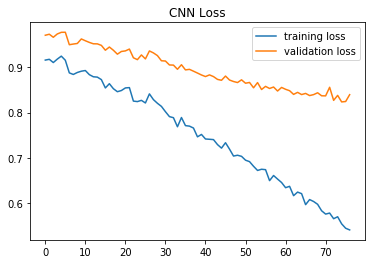

In [44]:
loss_vs_epoch = np.array(loss_vs_epoch)
plt.title('CNN Loss')
plt.plot(loss_vs_epoch[:,0][1:],label='training loss')
plt.plot(loss_vs_epoch[:,1][1:],label='validation loss')

plt.legend()

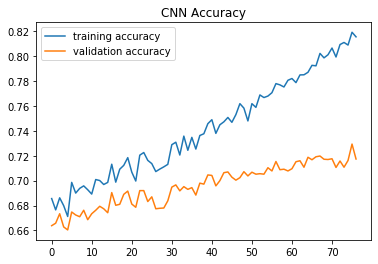

In [45]:
accuracy_vs_epoch = np.array(accuracy_vs_epoch)

plt.title('CNN Accuracy')
plt.plot(accuracy_vs_epoch[:,0][1:],label='training accuracy')
plt.plot(accuracy_vs_epoch[:,1][1:],label='validation accuracy')

plt.legend()

In [26]:
a = [1,2,3]

In [35]:
loss_vs_epoch_pre50 

array([[0.91845244, 0.96939093],
       [0.91595501, 0.97078699],
       [0.91768485, 0.97305059],
       [0.91053623, 0.96632773],
       [0.91815031, 0.97363806],
       [0.92468089, 0.9772501 ],
       [0.91560501, 0.97742265],
       [0.88771445, 0.94989783],
       [0.88424218, 0.95137745],
       [0.88861799, 0.95265412],
       [0.89143896, 0.96263176],
       [0.89292872, 0.958637  ],
       [0.88381189, 0.95499718],
       [0.87913185, 0.95192665],
       [0.87835783, 0.95177209],
       [0.8728804 , 0.94846487],
       [0.85448974, 0.93773311],
       [0.86383665, 0.94479454],
       [0.85282326, 0.93767166],
       [0.84617597, 0.92902112],
       [0.84876394, 0.9349882 ],
       [0.85450828, 0.93623984],
       [0.85519987, 0.94028115],
       [0.82546377, 0.92108613],
       [0.82435256, 0.9169209 ],
       [0.82706249, 0.92730731],
       [0.82132977, 0.91857761],
       [0.84137589, 0.93614835]])

pre50 arrays copied from earlier commit epochs 23-50

In [37]:
loss_vs_epoch = np.concatenate((loss_vs_epoch_pre50,loss_vs_epoch))

In [42]:
accuracy_vs_epoch =np.concatenate((accuracy_vs_epoch_pre50,accuracy_vs_epoch))

In [33]:
loss_vs_epoch

[[0.8287178874015808, 0.9318084716796875],
 [0.8206186294555664, 0.9258884787559509],
 [0.8137378692626953, 0.9144444465637207],
 [0.802065908908844, 0.9139114022254944],
 [0.7911832332611084, 0.9052160978317261],
 [0.7887923121452332, 0.9048795104026794],
 [0.7688114047050476, 0.895696759223938],
 [0.7891855239868164, 0.9056985378265381],
 [0.7712908983230591, 0.8943132758140564],
 [0.7701846361160278, 0.8955076932907104],
 [0.7659554481506348, 0.8914696574211121],
 [0.746590256690979, 0.8873549103736877],
 [0.7518309354782104, 0.8830804824829102],
 [0.7417992353439331, 0.879616379737854],
 [0.7411722540855408, 0.8832830190658569],
 [0.740441083908081, 0.8795152306556702],
 [0.7294455766677856, 0.8733474612236023],
 [0.7216572761535645, 0.8713928461074829],
 [0.7335485816001892, 0.8806959986686707],
 [0.7194112539291382, 0.8719683885574341],
 [0.7041488885879517, 0.8686679601669312],
 [0.7059153318405151, 0.8663979768753052],
 [0.7035338282585144, 0.8724050521850586],
 [0.695008099079

In [43]:
accuracy_vs_epoch

array([[0.6896, 0.6734],
       [0.6856, 0.6638],
       [0.6765, 0.6658],
       [0.6862, 0.6734],
       [0.6799, 0.6628],
       [0.6712, 0.6604],
       [0.6986, 0.6748],
       [0.69  , 0.6724],
       [0.6938, 0.671 ],
       [0.6958, 0.6762],
       [0.6927, 0.6686],
       [0.6892, 0.6734],
       [0.7009, 0.6762],
       [0.7001, 0.6794],
       [0.6969, 0.6774],
       [0.6986, 0.6742],
       [0.7132, 0.6904],
       [0.6988, 0.6802],
       [0.7092, 0.681 ],
       [0.7123, 0.689 ],
       [0.7185, 0.6916],
       [0.7069, 0.6812],
       [0.6997, 0.6786],
       [0.7205, 0.692 ],
       [0.7226, 0.692 ],
       [0.7163, 0.6832],
       [0.7137, 0.687 ],
       [0.7073, 0.6774],
       [0.7093, 0.6778],
       [0.7111, 0.678 ],
       [0.7131, 0.6838],
       [0.7289, 0.6948],
       [0.7309, 0.6966],
       [0.7206, 0.6918],
       [0.7358, 0.6952],
       [0.7244, 0.693 ],
       [0.7348, 0.6944],
       [0.7254, 0.6884],
       [0.7363, 0.698 ],
       [0.7377, 0.6972],


## save your model

In [43]:
torch.save(net.state_dict(), 'model.pt')

## Bonus round: data augmentation

implement this random rotation into your dataset object - but add an optional input argument to your dataset __init__ so that you can turn this on/off (only use data augmentation for the training dataset)

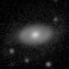

In [72]:
Image.open(filelist[1242])

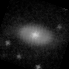

In [73]:
transforms.RandomRotation(180)( Image.open(filelist[1242]) )